# Sensor Model - CUDA accelerated


- cast
- compute sliding windows
- and mixture components $\tilde{y}$
- compute likelihood

In [7]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));
push!(LOAD_PATH, "../src");

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [16]:
#nbx --fname="src/sensor.jl"
using CUDA

## Raycaster

In [36]:
#nbx
include("../src/cuda_raycaster_line_map_b.jl")

function cast_cu(ps_::CuArray, segs_::CuArray; fov=2π, zmax::Float64=Inf)
    z_ = zmax*CUDA.ones(size(ps_, 1), 361)
    cast_cu!(z_,segs_,ps_; fov=fov)
    return z_
end

cast_cu (generic function with 1 method)

In [9]:
include("src/load_data.jl")

Loading `../data/data_4.jld2` ...

	_segs 	Vector{Segment}
	_boxes 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


In [18]:
segs_  = CuArray(stack(Vector.(_segs)));
boxes_ = CuArray(stack(Vector.(_boxes)));
ps_    = CuArray(stack(Vector.(_ps)));

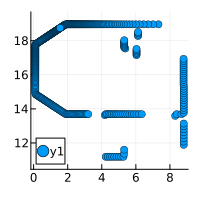

In [21]:
z_  = cast_cu(ps_, vcat(segs_,boxes_))
z   = Array(z_)
t   = 1
fov = 2π
_as = [range(-fov/2, fov/2, 361)...]

ys  = polar_inv(z[t,:], _as)
# ----------------------
plot(size=(200,200), aspect_ratio=:equal)
scatter!(ys.*_ps[t])

## Sliding window

 - $k$ - number of poses
 - $n$ - number of observations per scan
 - $m$ - number of mixture components

In [22]:
#nbx
"""
    slw_kernel!(x, w::Int, y)

CUDA kernel to compute sliding windows...
Takes CuArrays of shape `(k,n)` and `(k,n,m=2w+1)` 
and fills the latter with ...
"""
function slw_kernel!(x, w::Int, y)
    
    m = 2*w + 1
    
    # Make sure the arrays are 
    # of the right shape
    @assert ndims(x)  == 2
    @assert ndims(y)  == ndims(x) + 1
    @assert size(x,1) == size(y,1)
    @assert size(x,2) == size(y,2)
    @assert size(y,3) == m
    
    # Thread id's
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
        
    for j_pose = ix:sx:size(y,1), j_obs = iy:sy:size(y,2), j_mix = iz:sz:size(y,3)
        # Transform `1:m` to `-w:w`
        offset = j_mix-1-w
        
        # Wrap around, e.g. map `n+1` to `1`
        # Note that we have `size(x,2) == size(y,2)`
        j_mix_adj = mod(j_obs + offset - 1 , size(x,2)) + 1
        
        # Fill y's
        @inbounds y[j_pose, j_obs, j_mix] = x[j_pose, j_mix_adj]
    end
    return
end

"""
```julia
    y = slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4))
```
Computes sliding windows... takes a CuArray of shape `(k,n)` and returns a CuArray
of shape `(k,n,m)`, where `m = 2w+1`....
"""
function slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4))
    
    k = size(x, 1)
    n = size(x, 2)
    m = 2*w+1
    
    y = CUDA.ones(k,n,m)
    
    griddims = cuda_grid((k,n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims slw_kernel!(x, w, y)
    end
    
    return y
end;

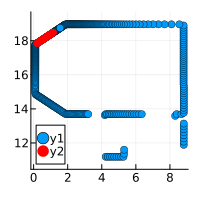

In [64]:
w = 20
m = 2*w+1
t = 1
i = 40


z_       = cast_cu(ps_, vcat(segs_))
z_tilde_ = slw_cu!(z_, w; blockdims=(8,8,4))

z       = Array(z_)
z_tilde = Array{Float64}(z_tilde_)

ys        = polar_inv(z[t,:], _as)
ys_tilde  = polar_inv(z_tilde[t,i,:], _as[i-w:i+w])

# ----------------------
plot(size=(200,200), aspect_ratio=:equal)
scatter!(ys.*_ps[t])
scatter!(ys_tilde.*_ps[t], c=:red, markerstrokewidth=0)

## Mixture components

In [66]:
#nbx
polar_inv_cu(z::CuArray, a::CuArray) = cat(z.*cos.(a), z.*sin.(a), dims=ndims(a)+1);


"""
    ys_tilde_ = get_ys_tilde_cu(zs_::CuArray, w::Int)    

Takes depth measurements and returns 
the point clouds for the gaussian mixtures ...
"""
function get_ys_tilde_cu(zs_::CuArray, as_::CuArray, w::Int)    

    zs_tilde_ = slw_cu!(zs_, w; blockdims=(8,8,4))
    as_tilde_ = slw_cu!(reshape(as_,1,:), w; blockdims=(8,8,4))
    
    ys_tilde_ = polar_inv_cu(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end;

In [77]:
unstack(x::Matrix) = [x[i,:] for i=1:size(x,1)]

unstack (generic function with 1 method)

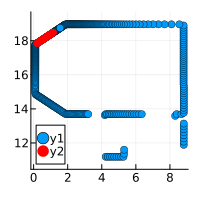

In [81]:
a_ = CuArray(_as)
ys_tilde_ = get_ys_tilde_cu(z_, a_, w)    
ys_tilde  = Array{Float64}(ys_tilde_)

# ----------------------
plot(size=(200,200), aspect_ratio=:equal)
scatter!(ys.*_ps[t])
scatter!(unstack(ys_tilde[t,i,:,:]).*_ps[t], c=:red, markerstrokewidth=0)


## Likelihoods

In [3]:
# #nbx
# """
#     log_p = sensor_smc_logpdf_cu(x::CuArray, ys_tilde::CuArray, sig, outlier)

# Evaluates the logpdf of an observation `x` (shape: `(n,2)`)
# with respect to a number of different gaussian mixtures (e.g. from family 
# of different poses) stacked along the first dim of `ys_tilde` (k,n,m,2) ...
# """
# function sensor_smc_logpdf_cu(x, ys_tilde, sig, outlier, outlier_vol=1.0)

#     n = size(ys_tilde,2)
#     m = size(ys_tilde,3)
    
#     xs = reshape(x, 1, n, 1, 2)
    
#     # Line by line...
#     # 1. Compute 1D Gaussians - (n,m,2)
#     # 2. Convert to 2D gausians - (n,m)
#     # 3. Convert to mixture of m 2D gausians (GM) - (n,)
#     # 4. Convert to mixture of `GM` and `anywhere` (D) - (n,)
#     # 5. Convert to Product of D's - ()
#     log_p = gaussian_logpdf(xs, ys_tilde, sig)
#     log_p = sum(log_p, dims=4)[:,:,:,1] 
#     log_p = logsumexp_cu(log_p .- log(m), 3)[:,:,1] 
#     log_p_or_any = log.((1-outlier)*exp.(log_p) .+ outlier/outlier_vol)
#     log_p = sum(log_p_or_any ,dims=2)[:,1]
    
#     return log_p
# end;

In [82]:
#nbx
function sensor_logpdf_cu(x::CuArray, y_tilde::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(y_tilde,1)
    m = size(y_tilde,2)
    
    @assert size(x,1) == size(y_tilde,1)
    
    x = reshape(x, n, 1, 2)
    
    # Compute 1D Gaussians - (n,m,2)
    # Convert to 2D gausians - (n,m)
    # Convert to mixture of m 2D gausians (GM) - (n,)
    # Convert to mixture of `GM` and `anywhere` (D) - (n,)
    # Convert to Product of D's - ()
    log_p = gaussian_logpdf(x, y_tilde, sig)
    log_p = sum(log_p, dims=3)[:,:,1] 
    log_p = logsumexp_cu(log_p .- log(m), 2)[:,1] 
    log_p_or_any_ = log.((1-outlier)*exp.(log_p) .+ outlier/outlier_vol)
    log_p = sum(log_p_or_any_)
    return log_p
end

sensor_logpdf_cu (generic function with 2 methods)

In [83]:
#nbx
using Gen
struct SensorDistribution_CUDA <: Distribution{Vector{Vector{Float64}}} 
end

const sensordist_cu = SensorDistribution_CUDA()

function Gen.logpdf(::SensorDistribution_CUDA, x, y_tilde_::CuArray, sig, outlier, outlier_vol=1.0)
    x_ = CuArray(stack(x))
    return sensor_logpdf_cu(x_, y_tilde_, sig, outlier, outlier_vol)
end
function Gen.random(::SensorDistribution_CUDA, y_tilde_::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(y_tilde_,1)
    m = size(y_tilde_,2)

    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution, e.g. over a  
            #       circular area with radius `zmax`.
            x_i = [Inf;Inf]
        else
            j   = rand(1:m)
            y   = Array(y_tilde_[i,j,:])
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    return x
end

(D::SensorDistribution_CUDA)(args...) = Gen.random(D, args...)
Gen.has_output_grad(::SensorDistribution_CUDA)    = false
Gen.has_argument_grads(::SensorDistribution_CUDA) = (false, false);

In [ ]:
#nbx
@gen function sensor_model_cu(p, w, s_noise, dropout)
    p_ = CuArray(Vector(p))
    zs_      = cast_cu(reshape(p_, 1,3))
    y_tilde_ = get_ys_tilde_cu(zs_, w)[1,:,:,:];
    
    x ~ sensordist_cu(y_tilde_, s_noise, dropout)
    return x
end